In [15]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()  # Convert to tensor and scale to [0,1]
])

In [4]:
mnist_train = datasets.MNIST(root='data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='data', train=False, transform=transform, download=True)

In [5]:
X = torch.stack([img.view(-1) for img, _ in mnist_train])
y = torch.tensor([label for _, label in mnist_train])

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)
print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Train set size: 36000
Validation set size: 12000
Test set size: 12000


In [8]:
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

In [9]:
def softmax(z):
    exp_z = torch.exp(z - torch.max(z, dim=1, keepdim=True).values)
    return exp_z / exp_z.sum(dim=1, keepdim=True)

In [10]:
def cross_entropy_loss(y_hat, y_true):
    eps = 1e-15
    y_hat = torch.clamp(y_hat, eps, 1 - eps)
    one_hot = torch.nn.functional.one_hot(y_true, num_classes=10).float()
    return -torch.mean(torch.sum(one_hot * torch.log(y_hat), dim=1))

In [11]:
n_features = 784
n_classes = 10
W = torch.zeros((n_features, n_classes), requires_grad=True)
b = torch.zeros(n_classes, requires_grad=True)

In [13]:
learning_rate = 0.01
epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [14]:
# --- Training loop ---
for epoch in range(epochs):
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0

    # ----- TRAINING PHASE -----
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = softmax(X_batch @ W + b)
        loss = cross_entropy_loss(y_pred, y_batch)

        # Backward pass
        loss.backward()

        # Gradient update (manual SGD)
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # Reset gradients
        W.grad.zero_()
        b.grad.zero_()


        # Accumulate batch loss
        epoch_loss += loss.item()
        # Compute training accuracy per batch
        preds = y_pred.argmax(dim=1)
        correct_train += (preds == y_batch).sum().item()
        total_train += y_batch.size(0)        

    # Compute average training loss for this epoch
    avg_train_loss = epoch_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # ----- VALIDATION PHASE -----
    with torch.no_grad():
        val_loss_total = 0.0
        correct = 0
        total = 0

        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = softmax(X_val_batch @ W + b)
            val_loss_total += cross_entropy_loss(y_val_pred, y_val_batch).item()

            # Compute accuracy
            y_val_pred_label = y_val_pred.argmax(dim=1)
            correct += (y_val_pred_label == y_val_batch).sum().item()
            total += y_val_batch.size(0)

        avg_val_loss = val_loss_total / len(val_loader)
        val_acc = correct / total

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

    # Print progress for this epoch
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Train Acc: {train_accuracies[-1]:.4f} | "
          f"Val Acc: {val_accuracies[-1]:.4f}")

Epoch 1/100 | Train Loss: 1.1687 | Val Loss: 0.7693 | Train Acc: 0.7976 | Val Acc: 0.8424
Epoch 2/100 | Train Loss: 0.6522 | Val Loss: 0.5962 | Train Acc: 0.8581 | Val Acc: 0.8572
Epoch 3/100 | Train Loss: 0.5412 | Val Loss: 0.5255 | Train Acc: 0.8706 | Val Acc: 0.8672
Epoch 4/100 | Train Loss: 0.4881 | Val Loss: 0.4855 | Train Acc: 0.8782 | Val Acc: 0.8746
Epoch 5/100 | Train Loss: 0.4552 | Val Loss: 0.4595 | Train Acc: 0.8836 | Val Acc: 0.8793
Epoch 6/100 | Train Loss: 0.4326 | Val Loss: 0.4407 | Train Acc: 0.8881 | Val Acc: 0.8834
Epoch 7/100 | Train Loss: 0.4158 | Val Loss: 0.4262 | Train Acc: 0.8914 | Val Acc: 0.8849
Epoch 8/100 | Train Loss: 0.4025 | Val Loss: 0.4148 | Train Acc: 0.8941 | Val Acc: 0.8869
Epoch 9/100 | Train Loss: 0.3916 | Val Loss: 0.4050 | Train Acc: 0.8967 | Val Acc: 0.8893
Epoch 10/100 | Train Loss: 0.3828 | Val Loss: 0.3971 | Train Acc: 0.8982 | Val Acc: 0.8908
Epoch 11/100 | Train Loss: 0.3751 | Val Loss: 0.3908 | Train Acc: 0.9000 | Val Acc: 0.8912
Epoch 12

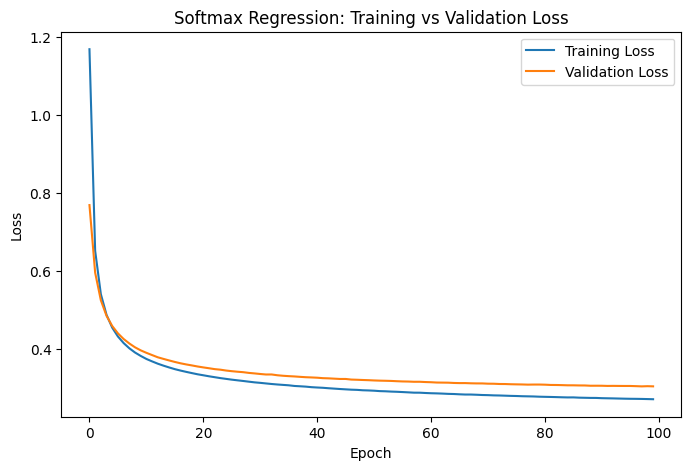

In [17]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Softmax Regression: Training vs Validation Loss')
plt.legend()
plt.show()

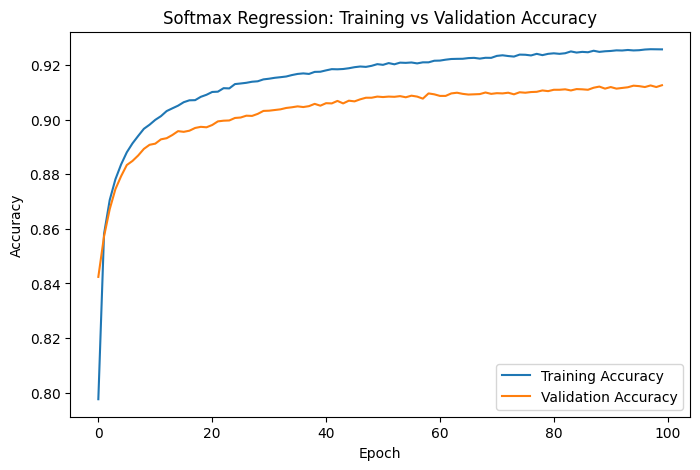

In [18]:
plt.figure(figsize=(8,5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Softmax Regression: Training vs Validation Accuracy')
plt.legend()
plt.show()


Final Test Accuracy: 0.9121


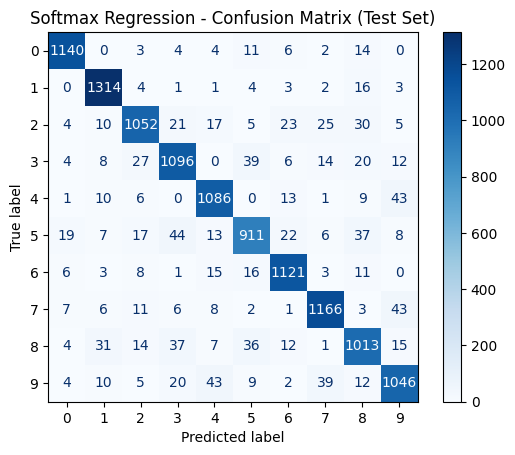

In [19]:
with torch.no_grad():
    logits_test = X_test @ W + b
    y_test_pred = softmax(logits_test)
    y_test_pred_label = y_test_pred.argmax(dim=1)

test_acc = (y_test_pred_label == y_test).float().mean().item()
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

cm = confusion_matrix(y_test, y_test_pred_label)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Softmax Regression - Confusion Matrix (Test Set)")
plt.show()

Accuracy for digit 0: 0.9628
Accuracy for digit 1: 0.9748
Accuracy for digit 2: 0.8826
Accuracy for digit 3: 0.8940
Accuracy for digit 4: 0.9290
Accuracy for digit 5: 0.8404
Accuracy for digit 6: 0.9468
Accuracy for digit 7: 0.9306
Accuracy for digit 8: 0.8658
Accuracy for digit 9: 0.8790


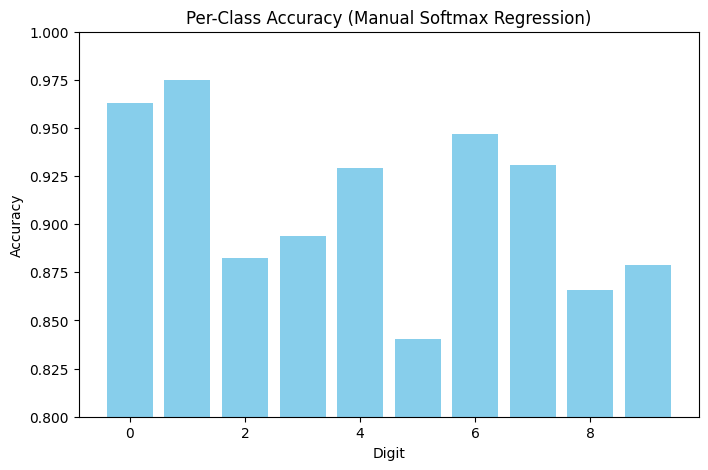

In [20]:
classes = list(range(10))
per_class_acc = []
for c in classes:
    mask = (y_test == c)
    acc_c = (y_test_pred_label[mask] == y_test[mask]).float().mean().item()
    per_class_acc.append(acc_c)
    print(f"Accuracy for digit {c}: {acc_c:.4f}")

plt.figure(figsize=(8,5))
plt.bar(classes, per_class_acc, color='skyblue')
plt.xlabel('Digit')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy (Manual Softmax Regression)')
plt.ylim(0.8, 1.0)
plt.show()

In [21]:
model_torch = nn.Sequential(
    nn.Linear(784, 10)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_torch.parameters(), lr=0.01)

In [22]:
epochs_builtin = 100
for epoch in range(epochs_builtin):
    total_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        outputs = model_torch(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    print(f"[PyTorch Model] Epoch {epoch+1}/{epochs_builtin} | "
          f"Loss: {total_loss/len(train_loader):.4f} | Train Acc: {correct/total:.4f}")

[PyTorch Model] Epoch 1/100 | Loss: 1.1796 | Train Acc: 0.7680
[PyTorch Model] Epoch 2/100 | Loss: 0.6558 | Train Acc: 0.8554
[PyTorch Model] Epoch 3/100 | Loss: 0.5435 | Train Acc: 0.8698
[PyTorch Model] Epoch 4/100 | Loss: 0.4897 | Train Acc: 0.8779
[PyTorch Model] Epoch 5/100 | Loss: 0.4567 | Train Acc: 0.8839
[PyTorch Model] Epoch 6/100 | Loss: 0.4339 | Train Acc: 0.8874
[PyTorch Model] Epoch 7/100 | Loss: 0.4167 | Train Acc: 0.8902
[PyTorch Model] Epoch 8/100 | Loss: 0.4034 | Train Acc: 0.8934
[PyTorch Model] Epoch 9/100 | Loss: 0.3928 | Train Acc: 0.8958
[PyTorch Model] Epoch 10/100 | Loss: 0.3836 | Train Acc: 0.8980
[PyTorch Model] Epoch 11/100 | Loss: 0.3757 | Train Acc: 0.8997
[PyTorch Model] Epoch 12/100 | Loss: 0.3695 | Train Acc: 0.9004
[PyTorch Model] Epoch 13/100 | Loss: 0.3636 | Train Acc: 0.9022
[PyTorch Model] Epoch 14/100 | Loss: 0.3587 | Train Acc: 0.9034
[PyTorch Model] Epoch 15/100 | Loss: 0.3541 | Train Acc: 0.9048
[PyTorch Model] Epoch 16/100 | Loss: 0.3499 | Tra

In [24]:
with torch.no_grad():
    outputs_test = model_torch(X_test)
    preds_test = outputs_test.argmax(dim=1)
    acc_torch_test = (preds_test == y_test).float().mean().item()

print(f"\nPyTorch Built-in Softmax Regression - Test Accuracy: {acc_torch_test:.4f}")


PyTorch Built-in Softmax Regression - Test Accuracy: 0.9122


Digit 0: 0.9628
Digit 1: 0.9740
Digit 2: 0.8842
Digit 3: 0.9013
Digit 4: 0.9281
Digit 5: 0.8404
Digit 6: 0.9451
Digit 7: 0.9290
Digit 8: 0.8632
Digit 9: 0.8790


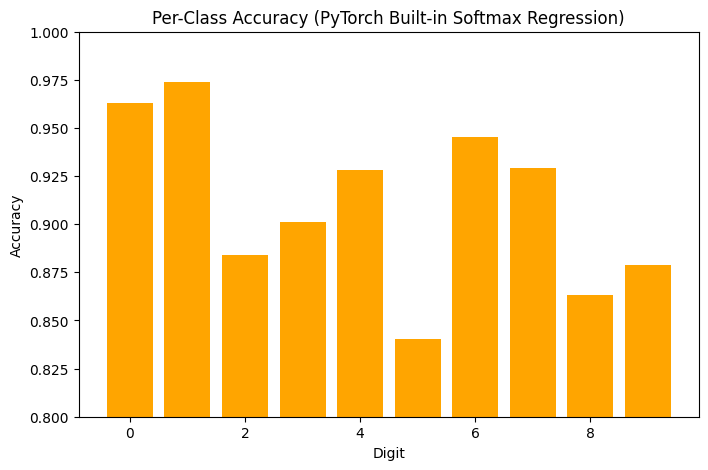

In [26]:
classes = list(range(10))
per_class_acc_torch = []

for c in classes:
    mask = (y_test == c)
    acc_c = (preds_test[mask] == y_test[mask]).float().mean().item()
    per_class_acc_torch.append(acc_c)
    print(f"Digit {c}: {acc_c:.4f}")

# Optional: visualize as bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(classes, per_class_acc_torch, color='orange')
plt.xlabel('Digit')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy (PyTorch Built-in Softmax Regression)')
plt.ylim(0.8, 1.0)
plt.show()

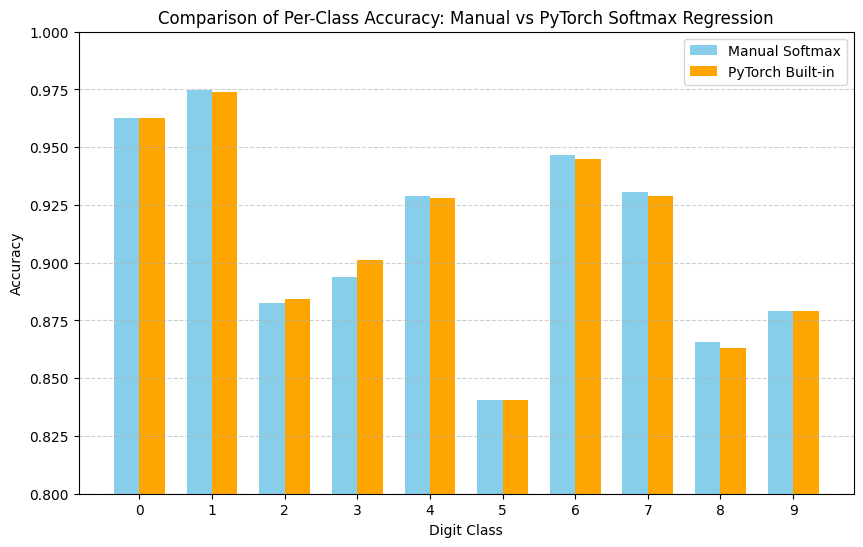

Digit | Manual Acc | PyTorch Acc | Difference
---------------------------------------------
   0   |   0.9628   |   0.9628   |   0.0000
   1   |   0.9748   |   0.9740   |   0.0007
   2   |   0.8826   |   0.8842   |   0.0017
   3   |   0.8940   |   0.9013   |   0.0073
   4   |   0.9290   |   0.9281   |   0.0009
   5   |   0.8404   |   0.8404   |   0.0000
   6   |   0.9468   |   0.9451   |   0.0017
   7   |   0.9306   |   0.9290   |   0.0016
   8   |   0.8658   |   0.8632   |   0.0026
   9   |   0.8790   |   0.8790   |   0.0000


In [27]:
manual_acc = np.array(per_class_acc)
torch_acc = np.array(per_class_acc_torch)

# --- Plot comparison ---
plt.figure(figsize=(10,6))
bar_width = 0.35
x = np.arange(len(classes))

plt.bar(x - bar_width/2, manual_acc, width=bar_width, label='Manual Softmax', color='skyblue')
plt.bar(x + bar_width/2, torch_acc, width=bar_width, label='PyTorch Built-in', color='orange')

plt.xlabel('Digit Class')
plt.ylabel('Accuracy')
plt.title('Comparison of Per-Class Accuracy: Manual vs PyTorch Softmax Regression')
plt.xticks(x, classes)
plt.ylim(0.8, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# --- Print numerical summary ---
print("Digit | Manual Acc | PyTorch Acc | Difference")
print("---------------------------------------------")
for c in range(10):
    diff = abs(manual_acc[c] - torch_acc[c])
    print(f"  {c:>2}   |   {manual_acc[c]:.4f}   |   {torch_acc[c]:.4f}   |   {diff:.4f}")